In [1]:
import pickle 
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from scipy.optimize import minimize
from IPython.display import display, Latex


In [2]:
d2metals = {
    '3': ['Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu'],
    '4': ['Nb', 'Mo', ],
    '5': ['W', ]
}

# for plotting
ele2col = {
    "Ti": "#808080",
    "V": "#ffcccb",
    "Cr": "k",
    "Mn": "#9b870c",
    "Fe": "r",
    "Co": "b",
    "Cu": "#FFFF00",
    "Nb": "cyan",
    "Mo": "#FFA500",
    "Sn": "k",
    "W": "fuchsia",
    "Ir": "b",
    "Ni": "#66FF00",
}

In [3]:
def plot_parabola(parabola):
    x = np.linspace(0, 4, 10)
    y = parabola[0]*x**2+parabola[1]*x
    plt.plot(x, y)
    
def formation_energy_mixing(ele1, ele2, concentrations, plotting=False):
    ox_quadratic_1 = mp_quadratic_equations_ox[ele1]
    ox_quadratic_2 = mp_quadratic_equations_ox[ele2]
    red_quadratic_1 = mp_quadratic_equations_red[ele2]
    red_quadratic_2 = mp_quadratic_equations_red[ele1]

    predicted_forms_1 = []
    predicted_forms_2 = []
    predicted_ox_change_1 = []
    predicted_ox_change_2 = []
    minima = []
    x_tots = []
    for conc in concentrations:
        
        o_1a, o_2a, o_3a = ox_quadratic_1
        r_1a, r_2a, r_3a = red_quadratic_1

        o_1b, o_2b, o_3b = ox_quadratic_2
        r_1b, r_2b, r_3b = red_quadratic_2
        if plotting:
            #print('checking {}'.format(conc))
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, r_1a, r_2a, True), bounds=[(0, 10)])
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, r_1b, r_2b, True), bounds=[(0, 10)])
            
        else:
            result_1 = minimize(oxidation_reduction_equation, 1, args=(conc, o_1a, o_2a, r_1a, r_2a),  bounds=[(0, 10)])
            # Note, the definition of concentration is different  between 1/2,
            # since it relates to the concentration of the element that is 
            # oxidisint or reducing.
            #handle this when plotting by flipping the x-axis horizontally
            result_2 = minimize(oxidation_reduction_equation, 1, args=(1-conc, o_1b, o_2b, r_1b, r_2b),  bounds=[(0, 10)])
        
        x_space = np.linspace(0, 3, 50)
        predicted_ox_change_1.append(result_1.x[0])
        # this can give problems depending on scipy version, might have to use result_1.fun
        predicted_forms_1.append(result_1.fun)
        predicted_ox_change_2.append(result_2.x[0])
        predicted_forms_2.append(result_2.fun)#result_2.fun[0] + diff*(1-conc))
        
        if plotting:
            mixed_1 = o_1a*(x_space**2)*(1-conc)**2+o_2a*x_space*(1-conc)+r_1a*(x_space**2)*conc**2+r_2a*x_space*conc
            ox1 = o_1a*x_space**2+o_2a*x_space
            red1 = r_1a*x_space**2+r_2a*x_space
            mixed_2 = o_1b*(x_space**2)*(conc)**2+o_2b*x_space*(conc)+(r_1b*((1-conc)*x_space)**2+r_2b*(1-conc)*x_space)
            ox2 = o_1b*x_space**2+o_2b*x_space
            red2 = r_1b*x_space**2+r_2b*x_space

            if min(mixed_1)<min(mixed_2):
                minima.append(min(mixed_1))
                x_tots.append(result_1.x[0])
                if conc not in [0, 1]:
                    plt.plot(x_space, mixed_1, label='mixed_{}{:.1f}{}{:.1f}'.format(ele1, 1-conc, ele2, conc), color='gray')
                    plt.plot(result_1.x[0], min(mixed_2), 'bo')
                if conc==0:
                    plt.plot(x_space, ox1, label=ele1+"_ox", color=ele2col[ele1[:-1]])
                    plt.plot(x_space, red1, label=ele2+"_red", color=ele2col[ele2[:-1]])
                if conc==1:
                    plt.legend(fontsize=13)
                    plt.xticks(fontsize=13)
                    plt.yticks(fontsize=13)
                    plt.savefig("{}_{}_mixing.pdf".format(ele1, ele2))
                    plt.show()
            else:
                minima.append(min(mixed_2))
                x_tots.append(result_2.x[0])
                if conc not in [0, 1]:
                    plt.plot(x_space, mixed_2, label='mixed_{}{:.1f}{}{:.1f}'.format(ele1, 1-conc, ele2, conc), )#color='gray')
                    plt.plot(result_2.x[0], min(mixed_2), 'bo')
                if conc==0:
                    plt.plot(x_space, ox2, label=ele2+"_ox", color=ele2col[ele2[:-1]])
                    plt.plot(x_space, red2, label=ele1+"_red", color=ele2col[ele1[:-1]])
                if conc==1:
                    plt.legend(fontsize=13)
                    plt.xticks(fontsize=13)
                    plt.yticks(fontsize=13)
                    plt.legend()
                    plt.savefig("{}_{}_mixing.pdf".format(ele1, ele2))
                    plt.show()
    
    if plotting:
        print("X_tots")
        for x in x_tots:
            print("{:.2f}".format(x), end=", ")
        plt.plot(concentrations, minima)
        plt.plot([0, 1], [minima[0], minima[-1]], 'k--')
        plt.legend(fontsize=13)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.savefig("deltaC_1c.pdf")
        plt.show()

        ox2 = o_1b*x_space**2+o_2b*x_space
        red2 = r_1b*x_space**2+r_2b*x_space
        plt.plot(x_space, ox2, label=ele2[:-1], color=ele2col[ele2[:-1]])
        plt.plot(x_space, red2, label=ele1[:-1], color=ele2col[ele1[:-1]])
        plt.ylim(top=1)
        plt.legend(fontsize=13)
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.savefig("indiv_parabolas_1a.pdf")
        plt.show()
        
    xs_1 = []
    xs_2 = []
    for conc in concentrations:
        # need to shift the energies so that either end is set to 0
        # so shift every point proportionally
        xs_1.append(predicted_forms_1[0]*(1-conc)+predicted_forms_1[-1]*(conc))
        xs_2.append(predicted_forms_2[0]*(1-conc)+predicted_forms_2[-1]*(conc))
        
    return np.array(predicted_forms_1)-xs_1, np.array(predicted_forms_2)-xs_2, predicted_ox_change_1, predicted_ox_change_2

def oxidation_reduction_equation(x, ox_conc, o1, o2, r1, r2, plot=False):
    """
    Defines the equation to optimize oxidation state when mixed
    Args:
    x: The amount of oxidation state change
    ox_conc: The concentration of the oxidising element between 0 and 1
    o1, o2, o3: Define the quadratic equation for the oxidising element
    r1, r2, r3: Define the quadratic equation for the reducing element
    """
    return (o1*x**2*(1-ox_conc)**2+o2*x*(1-ox_conc))+(r1*(ox_conc*x)**2+r2*(ox_conc*x))


def find_nearest(array, value):
    """
    Helper function to find the closest conc
    """
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx


In [4]:
mp_quadratic_equations_ox = pickle.load(open('make_quadratics/mp_quadratic_equations_ox.p', 'rb'))
mp_quadratic_equations_red = pickle.load(open('make_quadratics/mp_quadratic_equations_red.p', 'rb'))

binary_pairing_data = pickle.load(open('data_gather/binary_pairing_data.p', 'rb'))

# iterate over these eqs, removing the oxidation number label to get all the elements 
set_of_elements = set([x[:-1] for x in mp_quadratic_equations_ox])
# these give issues in that they cause a bug where the code finds or Ir Yb entries 
# when it shouldn't. I gets mistakenly matched with Ir data, and Y with Yb data.
set_of_elements.remove("I")
set_of_elements.remove("Y")


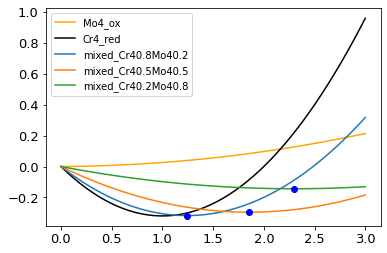

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


X_tots
1.00, 1.24, 1.86, 2.30, 0.00, 

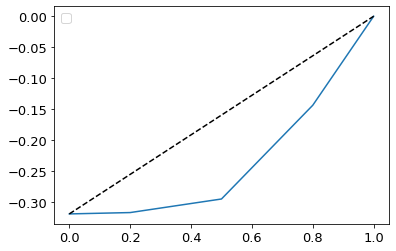

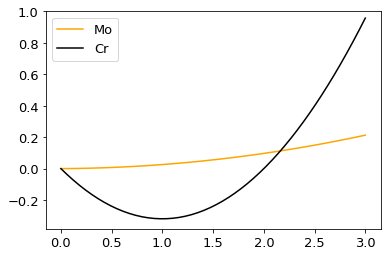

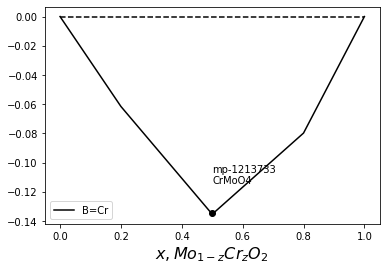

In [5]:
oxidation_state = 4
for housing_element in ['Mo']:
    house_ele_ox = housing_element+str(oxidation_state)
    #print(house_ele_ox)
    if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
        print("Missing eq for {}".format(housing_element))
        continue
    
    pairings = []
    ground_states =  []
    zs = [0, 0.2, 0.5, 0.8, 1.0]

    for ele in ['Cr']:

        dope_ele_ox = ele+str(oxidation_state)
        if ele==housing_element:
            continue

        else: 
            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, plotting=True)

        can_reduce = True
        can_oxidise = True
        # check if it found any solutions 
        if sum(ox_1)==0:
            can_reduce = False
        if sum(ox_2)==0:
            can_oxidise = False 
            
        if can_reduce:
            plt.plot(zs, pred_1, label="B={}".format(ele), color=ele2col[ele])
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        if can_oxidise:
            plt.plot(zs, pred_2, label="B={}".format(ele), ls='-', color=ele2col[ele])#, 'r-')
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        
        if ele<housing_element:
            info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])

                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])
        else:
            info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                        plt.text(conc2plot, info_dict[match]['MP ΔD']+0.02, 
                                 info_dict[match]['MP_id']+"\n"+info_dict[match]['MP_name'])
        
    plt.legend()
    plt.xlabel("$x, {}_{{1-z}}Cr_{{z}}O_{{2}}$".format(housing_element, ), fontsize=16)
    plt.savefig("Cr_Mo_1d.pdf")
        

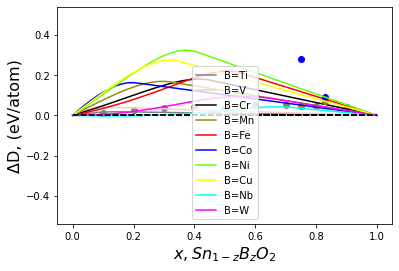

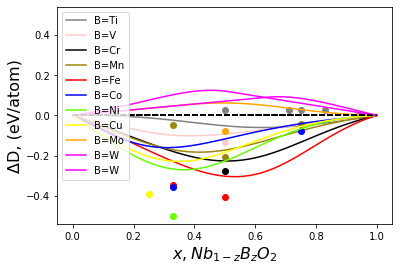

In [6]:
oxidation_state = 4
for housing_element in ['Sn', 'Nb']:
    house_ele_ox = housing_element+str(oxidation_state)
    #print(house_ele_ox)
    if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
        print("Missing eq for {}".format(housing_element))
        continue
    
    pairings = []
    ground_states =  []
    zs = np.linspace(0, 1.00, 51)

    for ele in d2metals['3']+d2metals['4']+d2metals['5']:
        #print(ele)
        dope_ele_ox = ele+str(oxidation_state)
        if ele==housing_element:
            continue

        else: 
            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )

        can_reduce = True
        can_oxidise = True
        # check if it found any solutions 
        if sum(ox_1)==0:
            can_reduce = False
        if sum(ox_2)==0:
            can_oxidise = False 
            
        if can_reduce:
            plt.plot(zs, pred_1, label="B={}".format(ele), color=ele2col[ele])
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        if can_oxidise:
            plt.plot(zs, pred_2, label="B={}".format(ele), ls='-', color=ele2col[ele])#, 'r-')
            plt.plot([zs[0], zs[-1]], [0, 0], 'k--')
        
        if ele<housing_element:
            info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
        else:
            info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(oxidation_state)]
            for match in info_dict:
                if ele in match:
                    conc2plot = float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])
                else:
                    conc2plot = 1-float(match.split("_")[1])
                    if info_dict[match]['Coordination match']:
                        plt.plot(conc2plot, info_dict[match]['MP ΔD'], 'o', color=ele2col[ele])

        
    plt.legend()
    plt.xlabel("$x, {}_{{1-z}}B_{{z}}O_{{2}}$".format(housing_element, ), fontsize=16)
    plt.ylabel("ΔD, (eV/atom)", fontsize=16)
    plt.ylim(-0.54, 0.54)
    plt.savefig("{}_higherdmixing.pdf".format(housing_element))
    plt.show()
        
        

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 777
MAE for unfiltered: 0.236
total matches with good geom: 232
MAE for filtered: 0.127


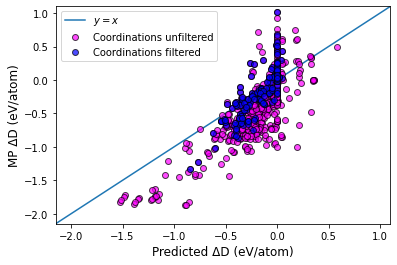

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 1369
MAE for unfiltered: 0.248
total matches with good geom: 176
MAE for filtered: 0.117


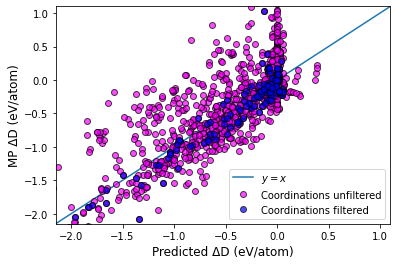

Checking oxides of type as below


<IPython.core.display.Latex object>

total matches: 932
MAE for unfiltered: 0.122
total matches with good geom: 298
MAE for filtered: 0.096


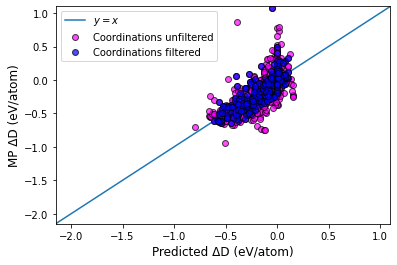

In [7]:
ox2oxide_type = {
    "2": "$A_{1-z}B_{z}O$",
    "3": "$A_{1-z}B_{z}O_{1.5}$",
    "4": "$A_{1-z}B_{z}O_{2}$"
}
maes = []
num_oxides = []

good_maes = []
num_good_oxides = []
# dictionary mapping oxidation state to x/y plot for all oxides 
ox2xs = defaultdict()
ox2ys = defaultdict()
# dictionary mapping oxidation state to x/y plot for oxides conditioned on geometry
ox2good_xs = defaultdict()
ox2good_ys = defaultdict()

# dictionary mapping oxidation state to form ene x/y plot for all oxides 
ox2pred_form_enes = defaultdict()
ox2mp_form_enes = defaultdict()
ox2weighted_avgs = defaultdict()
# dictionary mapping oxidation state to form ene x/y plot for oxides conditioned on geometry
ox2good_pred_form_enes = defaultdict()
ox2good_mp_form_enes = defaultdict()
ox2good_weighted_avgs = defaultdict()


for oxidation_state in [2, 3, 4]:
    print("Checking oxides of type as below")
    display(Latex(ox2oxide_type[str(oxidation_state)]))
    data_dict = defaultdict()
    seen_combinations = []
    lower_lim = -2.15
    upper_lim = 1.1
    for housing_element in set_of_elements:
        house_ele_ox = housing_element+str(oxidation_state)
        if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
            print("Missing eq for {}".format(housing_element))
            continue

        pairings = []
        ground_states =  []
        zs = np.linspace(0, 1.00, 51)

        for ele in set_of_elements:
            dope_ele_ox = ele+str(oxidation_state)
            if housing_element+ele in seen_combinations or ele+housing_element in seen_combinations or ele==housing_element:
                continue
            else:
                seen_combinations.append(ele+housing_element)
            if ele<housing_element:
                info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(int(oxidation_state))]
            else:
                info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(int(oxidation_state))]
            if len(info_dict)==0:
                continue

            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )
            for ele_conc in info_dict:
                conc = float(ele_conc.split("_")[1])
                #closest_idx = find_nearest(zs, conc)
                if ele+"_{:.2f}".format(conc)==ele_conc:# in info_dict.keys():
                    # the 'element' variable is the one with that conc
                    # the ele conc is the one we get a ΔD value for at 
                    # given conc, and this has to match the way
                    # the weighted average was calculated
                    # this key will be accessed later
                    inner_key = ele+housing_element+"{:.2f}".format(conc)
                    closest_idx = find_nearest(zs, conc)

                elif housing_element+"_{:.2f}".format(conc)==ele_conc:
                    # the 'housing_element' is the one with that conc
                    inner_key = housing_element+ele+"{:.2f}".format(conc)
                    # since the ΔD is calculated for ele conc, need to switch 
                    # to the other side of the diagram
                    closest_idx = find_nearest(zs, 1-conc)
                    
                if pred_2[closest_idx]<pred_1[closest_idx]:
                    ox_change = ox_2[closest_idx]
                else:
                    ox_change = ox_1[closest_idx]

                data_dict[inner_key] = {
                    "predicted ΔD": min(pred_2[closest_idx], pred_1[closest_idx]),
                    "true ΔD": info_dict[ele_conc]['MP ΔD'],
                    "predicted formation energy": min(pred_2[closest_idx], pred_1[closest_idx]) + info_dict[ele_conc]['MP weighted average'],
                    "true formation energy": info_dict[ele_conc]['MP weighted average']+info_dict[ele_conc]['MP ΔD'],
                    "weighted average of refs": info_dict[ele_conc]['MP weighted average'],
                    "coordination_match": info_dict[ele_conc]['Coordination match'],
                    "x_tot": ox_change,
                    "mp_id": info_dict[ele_conc]['MP_id'],
                    "mp_name": info_dict[ele_conc]['MP_name'],
                    "motifs": info_dict[ele_conc]['motifs'],
                }
                
    plt.plot([lower_lim, upper_lim], [lower_lim, upper_lim], label='$y=x$')
    xs = []
    ys = []
    pred_form_enes = []
    mp_form_enes = []
    weighted_avgs = []
    for key, val in data_dict.items():
        xs.append(val['predicted ΔD'])
        ys.append(val['true ΔD'])
        
        pred_form_enes.append(val['predicted formation energy'])
        mp_form_enes.append(val['true formation energy'])
        weighted_avgs.append(val['weighted average of refs'])
    print("total matches: {}".format(len(xs)))
    plt.plot(xs, ys, 'o', color='fuchsia', alpha=0.7, label='Coordinations unfiltered', markeredgecolor='k')
    print("MAE for unfiltered: {:.3f}".format(np.mean(abs(np.array(xs)-np.array(ys)))))
    plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
    plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
    maes.append(np.mean(abs(np.array(xs)-np.array(ys))))
    num_oxides.append(len(xs))
    ox2xs[oxidation_state] = xs
    ox2ys[oxidation_state] = ys
    ox2pred_form_enes[oxidation_state] = pred_form_enes
    ox2mp_form_enes[oxidation_state] = mp_form_enes
    ox2weighted_avgs[oxidation_state] = weighted_avgs

    xs = []
    ys = []
    pred_form_enes = []
    mp_form_enes = []
    weighted_avgs = []
    for key, val in data_dict.items():
        if not val['coordination_match']:
            # bad geometry, skip
            continue
        xs.append(val['predicted ΔD'])
        ys.append(val['true ΔD'])
        
        pred_form_enes.append(val['predicted formation energy'])
        mp_form_enes.append(val['true formation energy'])
        weighted_avgs.append(val['weighted average of refs'])
#         if abs(xs[-1]-ys[-1])>0.5:
#             plt.text(xs[-1], ys[-1], "{}".format(key))

    ox2good_xs[oxidation_state] = xs
    ox2good_ys[oxidation_state] = ys
    ox2good_pred_form_enes[oxidation_state] = pred_form_enes
    ox2good_mp_form_enes[oxidation_state] = mp_form_enes
    ox2good_weighted_avgs[oxidation_state] = weighted_avgs
    print("total matches with good geom: {}".format(len(xs)))
    plt.plot(xs, ys, 'o', color='b', alpha=0.7, label='Coordinations filtered', markeredgecolor='k')
    print("MAE for filtered: {:.3f}".format(np.mean(abs(np.array(xs)-np.array(ys)))))
    plt.xlim(lower_lim, upper_lim)
    plt.ylim(lower_lim, upper_lim)
    plt.legend()
    plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
    plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
    plt.savefig("parities_ox_state_{}.pdf".format(oxidation_state))
    plt.show()
    good_maes.append(np.mean(abs(np.array(xs)-np.array(ys))))
    num_good_oxides.append(len(xs))


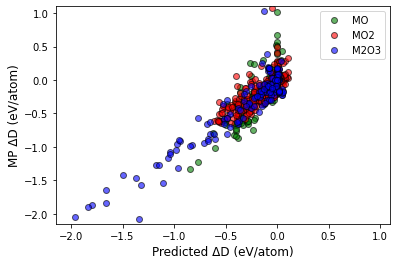

In [8]:
plt.plot(ox2good_xs[2], ox2good_ys[2], 'o', color='g', alpha=0.6, label='MO', markeredgecolor='k')
plt.plot(ox2good_xs[4], ox2good_ys[4], 'o', color='r', alpha=0.6, label='MO2', markeredgecolor='k')
plt.plot(ox2good_xs[3], ox2good_ys[3], 'o', color='b', alpha=0.6, label='M2O3', markeredgecolor='k')
plt.xlim(lower_lim, upper_lim)
plt.ylim(lower_lim, upper_lim)
plt.legend()
plt.xlabel("Predicted ΔD (eV/atom)", fontsize=12)
plt.ylabel("MP ΔD (eV/atom)", fontsize=12)
plt.savefig("parity_filtered_all.pdf")


Text(0, 0.5, 'MP Δ$E_{f}$ (eV/atom)')

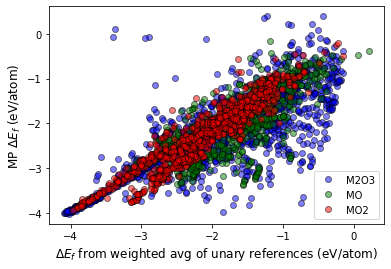

In [9]:
plt.plot(ox2weighted_avgs[3], ox2mp_form_enes[3], 'o', color='b', alpha=0.5, label='M2O3', markeredgecolor='k')
plt.plot(ox2weighted_avgs[2], ox2mp_form_enes[2], 'o', color='g', alpha=0.5, label='MO', markeredgecolor='k')
plt.plot(ox2weighted_avgs[4], ox2mp_form_enes[4], 'o', color='r', alpha=0.5, label='MO2', markeredgecolor='k')
#plt.xlim(-4.2, 0.6)
#plt.ylim(-4.2, 0.6)
plt.legend()
plt.xlabel("Δ$E_{f}$ from weighted avg of unary references (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
#plt.savefig("parity_form_ene_no_filter.pdf")

Text(0, 0.5, 'MP Δ$E_{f}$ (eV/atom)')

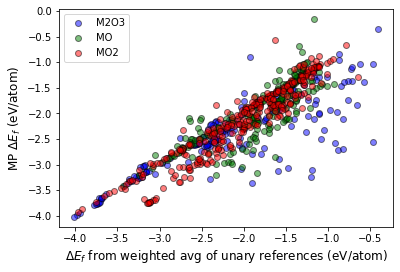

In [10]:
plt.plot(ox2good_weighted_avgs[3], ox2good_mp_form_enes[3], 'o', color='b', alpha=0.5, label='M2O3', markeredgecolor='k')
plt.plot(ox2good_weighted_avgs[2], ox2good_mp_form_enes[2], 'o', color='g', alpha=0.5, label='MO', markeredgecolor='k')
plt.plot(ox2good_weighted_avgs[4], ox2good_mp_form_enes[4], 'o', color='r', alpha=0.5, label='MO2', markeredgecolor='k')
#plt.xlim(-4.2, 0.6)
#plt.ylim(-4.2, 0.6)
plt.legend()
plt.xlabel("Δ$E_{f}$ from weighted avg of unary references (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
#plt.savefig("parity_form_ene_no_filter.pdf")

MAE for M2O3: 0.248
MAE for MO: 0.236
MAE for MO2: 0.122


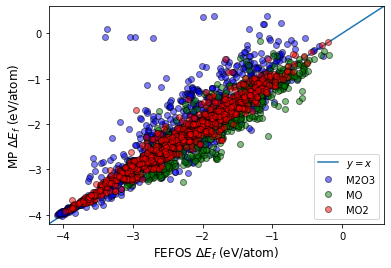

In [17]:
plt.plot([-4.2, 0.6], [-4.2, 0.6], label='$y=x$')
plt.plot(ox2pred_form_enes[3], ox2mp_form_enes[3], 'o', color='b', alpha=0.5, label='M2O3', markeredgecolor='k')
print("MAE for M2O3: {:.3f}".format(np.mean(abs(np.array(ox2pred_form_enes[3])-np.array(ox2mp_form_enes[3])))))
plt.plot(ox2pred_form_enes[2], ox2mp_form_enes[2], 'o', color='g', alpha=0.5, label='MO', markeredgecolor='k')
print("MAE for MO: {:.3f}".format(np.mean(abs(np.array(ox2pred_form_enes[2])-np.array(ox2mp_form_enes[2])))))
plt.plot(ox2pred_form_enes[4], ox2mp_form_enes[4], 'o', color='r', alpha=0.5, label='MO2', markeredgecolor='k')
print("MAE for MO2: {:.3f}".format(np.mean(abs(np.array(ox2pred_form_enes[4])-np.array(ox2mp_form_enes[4])))))
plt.xlim(-4.2, 0.6)
plt.ylim(-4.2, 0.6)
plt.legend()
plt.xlabel("FEFOS Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.savefig("parity_form_ene_no_filter.pdf")

MAE for MO-type: 0.127
MAE for MO2-type: 0.096
MAE for M2O3-type: 0.117


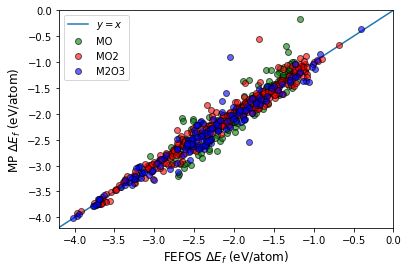

In [18]:
plt.plot([-4.2, 0.6], [-4.2, 0.6], label='$y=x$')
plt.plot(ox2good_pred_form_enes[2], ox2good_mp_form_enes[2], 'o', color='g', alpha=0.6, label='MO', markeredgecolor='k')
print("MAE for MO-type: {:.3f}".format(np.mean(abs(np.array(ox2good_pred_form_enes[2])-np.array(ox2good_mp_form_enes[2])))))
plt.plot(ox2good_pred_form_enes[4], ox2good_mp_form_enes[4], 'o', color='r', alpha=0.6, label='MO2', markeredgecolor='k')
print("MAE for MO2-type: {:.3f}".format(np.mean(abs(np.array(ox2good_pred_form_enes[4])-np.array(ox2good_mp_form_enes[4])))))
plt.plot(ox2good_pred_form_enes[3], ox2good_mp_form_enes[3], 'o', color='b', alpha=0.6, label='M2O3', markeredgecolor='k')
print("MAE for M2O3-type: {:.3f}".format(np.mean(abs(np.array(ox2good_pred_form_enes[3])-np.array(ox2good_mp_form_enes[3])))))
plt.xlim(-4.2, 0.0)
plt.ylim(-4.2, 0.0)
plt.legend()
plt.xlabel("FEFOS Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.ylabel("MP Δ$E_{f}$ (eV/atom)", fontsize=12)
plt.savefig("parity_form_ene_filter.pdf")


In [13]:
total_oxides = sum(num_oxides)
unfiltered_avg = 0
for num_ox, mae in zip(num_oxides, maes):
    unfiltered_avg+=num_ox*mae*(1.0/total_oxides)
print("Total MAE for unfiltered: {:.3f} eV/atom".format(unfiltered_avg))
total_oxides = sum(num_good_oxides)
filtered_avg = 0
for num_ox, mae in zip(num_good_oxides, good_maes):
    filtered_avg+=num_ox*mae*(1.0/total_oxides)
print("Total MAE for filtered: {:.3f} eV/atom".format(filtered_avg))


Total MAE for unfiltered: 0.207 eV/atom
Total MAE for filtered: 0.111 eV/atom


### Printing for spreadsheet

In [14]:
ox2oxide_type = {
    "2": "$A_{1-z}B_{z}O$",
    "3": "$A_{1-z}B_{z}O_{1.5}$",
    "4": "$A_{1-z}B_{z}O_{2}$"
}
for oxidation_state in [2, 3, 4]:
    print("Checking oxides of type as below")
    display(Latex(ox2oxide_type[str(oxidation_state)]))
    data_dict = defaultdict()
    seen_combinations = []

    for housing_element in set_of_elements:
        house_ele_ox = housing_element+str(oxidation_state)
        if (house_ele_ox not in mp_quadratic_equations_ox.keys() or house_ele_ox not in mp_quadratic_equations_red.keys()):
            print("Missing eq for {}".format(housing_element))
            continue

        pairings = []
        ground_states =  []
        zs = np.linspace(0, 1.00, 51)

        for ele in set_of_elements:
            dope_ele_ox = ele+str(oxidation_state)
            if housing_element+ele in seen_combinations or ele+housing_element in seen_combinations or ele==housing_element:
                continue
            else:
                seen_combinations.append(ele+housing_element)
            if ele<housing_element:
                info_dict = binary_pairing_data[ele+"_"+housing_element+"_"+str(int(oxidation_state))]
            else:
                info_dict = binary_pairing_data[housing_element+"_"+ele+"_"+str(int(oxidation_state))]
            if len(info_dict)==0:
                continue

            pred_1, pred_2, ox_1, ox_2 = formation_energy_mixing(dope_ele_ox, house_ele_ox,
                                                                 zs, )
            for ele_conc in info_dict:
                conc = float(ele_conc.split("_")[1])
                #closest_idx = find_nearest(zs, conc)
                if ele+"_{:.2f}".format(conc)==ele_conc:# in info_dict.keys():
                    # the 'element' variable is the one with that conc
                    # the ele conc is the one we get a ΔD value for at 
                    # given conc, and this has to match the way
                    # the weighted average was calculated
                    # this key will be accessed later
                    inner_key = ele+housing_element+"{:.2f}".format(conc)
                    closest_idx = find_nearest(zs, conc)

                elif housing_element+"_{:.2f}".format(conc)==ele_conc:
                    # the 'housing_element' is the one with that conc
                    inner_key = housing_element+ele+"{:.2f}".format(conc)
                    # since the ΔD is calculated for ele conc, need to switch 
                    # to the other side of the diagram
                    closest_idx = find_nearest(zs, 1-conc)
                    
                if pred_2[closest_idx]<pred_1[closest_idx]:
                    ox_change = ox_2[closest_idx]
                else:
                    ox_change = ox_1[closest_idx]

                data_dict[inner_key] = {
                    "predicted ΔD": min(pred_2[closest_idx], pred_1[closest_idx]),
                    "true ΔD": info_dict[ele_conc]['MP ΔD'],
                    "predicted formation energy": min(pred_2[closest_idx], pred_1[closest_idx]) + info_dict[ele_conc]['MP weighted average'],
                    "true formation energy": info_dict[ele_conc]['MP weighted average']+info_dict[ele_conc]['MP ΔD'],
                    "weighted average of refs": info_dict[ele_conc]['MP weighted average'],
                    "coordination_match": info_dict[ele_conc]['Coordination match'],
                    "x_tot": ox_change,
                    "mp_id": info_dict[ele_conc]['MP_id'],
                    "mp_name": info_dict[ele_conc]['MP_name'],
                    "motifs": info_dict[ele_conc]['motifs'],
                }
                print(data_dict[inner_key]['mp_name'], end=", ")
                print(data_dict[inner_key]['mp_id'], end=", ")
                print("{:.4f}".format(data_dict[inner_key]['true formation energy']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['predicted formation energy']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['true ΔD']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['predicted ΔD']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['weighted average of refs']), end=", ")
                print("{:.4f}".format(data_dict[inner_key]['x_tot']), end=", ")
                print(data_dict[inner_key]['coordination_match'], end=", ")
                motifs2print = ""
                for motif in data_dict[inner_key]['motifs']:
                    motifs2print+=motif+"/"
                motifs2print = motifs2print[:-1]
                print(motifs2print)




Checking oxides of type as below


<IPython.core.display.Latex object>

FeCoO2, mp-1097012, -0.6152, -1.3821, 0.7669, 0.0000, -1.3821, 0.0000, False, octahedral/unrecognized
Na2CoO3, mp-777786, -1.5277, -1.3763, -0.1514, 0.0000, -1.3763, 0.0000, False, unrecognized/tetrahedral
NaCoO2, mp-18921, -1.5701, -1.3531, -0.2170, 0.0000, -1.3531, 0.0000, True, octahedral
NaCo2O3, mp-1295695, -1.4494, -1.3298, -0.1196, 0.0000, -1.3298, 0.0000, False, tetrahedral
NaCo3O4, mp-759399, -1.1424, -1.3182, 0.1758, 0.0000, -1.3182, 0.0000, True, square pyramidal/octahedral/unrecognized
Li7Co5O12, mp-1174246, -1.7496, -1.6361, -0.1881, -0.0746, -1.5615, 1.8024, True, octahedral
Li3Co13O16, mp-867584, -1.3600, -1.4146, 0.0127, -0.0418, -1.3728, 1.1917, True, octahedral
Li5Co3O8, mp-1173996, -1.7329, -1.6482, -0.1516, -0.0668, -1.5814, 1.8404, True, octahedral/unrecognized
Li2CoO3, mp-1173879, -1.7802, -1.6568, -0.1790, -0.0556, -1.6012, 1.8496, True, octahedral
Li9Co7O16, mp-1175419, -1.7521, -1.6288, -0.2005, -0.0773, -1.5516, 1.7764, True, octahedral
LiCo6O7, mp-773572, -1.

CsFeO2, mp-1080749, -1.7336, -1.4881, -0.3229, -0.0774, -1.4106, 1.0993, False, unrecognized/tetrahedral
Sr3Fe2O5, mp-19218, -2.4267, -2.4380, 0.0113, 0.0000, -2.4380, 0.0000, False, bcc/unrecognized
SrFeO2, mp-21145, -2.2915, -2.2785, -0.0130, 0.0000, -2.2785, 0.0000, False, bcc/unrecognized
Sr2FeO3, mp-1071505, -2.5637, -2.5443, -0.0194, 0.0000, -2.5443, 0.0000, False, unrecognized
FeCuO2, mp-510281, -1.3203, -1.2113, -0.1090, 0.0000, -1.2113, 0.0000, False, octahedral/unrecognized
TlFeO2, mp-607310, -1.2222, -0.8458, -0.2638, 0.1126, -0.9584, 0.0000, False, unrecognized/tetrahedral
Na4MoO5, mp-29984, -2.0241, -1.5534, -0.6843, -0.2136, -1.3398, 2.5134, False, octahedral/unrecognized
NaMoO2, mp-578610, -1.8945, -1.7101, -0.6792, -0.4948, -1.2153, 3.8411, True, octahedral
Na3MoO4, mp-1210288, -1.9867, -1.5745, -0.6676, -0.2555, -1.3191, 2.6447, False, tetrahedral
Li2MoO3, mp-1223324, -2.1230, -2.0504, -0.6136, -0.5410, -1.5094, 3.0089, True, square pyramidal/octahedral/unrecognized
Li

Na2IrO3, mp-754844, -1.5424, -1.3747, -0.3840, -0.2162, -1.1585, 2.9466, False, octahedral/unrecognized
Na2TbO3, mp-1221290, -2.4507, -2.2493, -1.0597, -0.8583, -1.3910, 1.4736, False, octahedral
Na5TbO6, mp-1210242, -1.7438, -1.8894, -0.3369, -0.4825, -1.4069, 1.2212, False, octahedral
NaTbO2, mp-6964, -3.1342, -2.7134, -1.7590, -1.3383, -1.3751, 2.0000, False, octahedral/unrecognized
NaDyO2, mp-752672, -3.1553, -2.7265, -1.7758, -1.3470, -1.3795, 2.0000, False, octahedral/unrecognized
NaTi2O3, mp-754375, -2.7794, -2.6846, -0.3670, -0.2722, -2.4124, 4.3464, True, octahedral
NaTiO2, mp-7002, -2.7898, -2.4535, -0.6249, -0.2885, -2.1650, 3.7443, True, octahedral
Na2TiO3, mp-752423, -2.7489, -2.1336, -0.8313, -0.2160, -1.9176, 3.0270, False, octahedral/unrecognized
Na5Ti3O8, mp-759473, -2.7252, -2.2173, -0.7457, -0.2379, -1.9794, 3.1948, True, octahedral/unrecognized
Na11Ti10O21, mp-532249, -2.7498, -2.4119, -0.6202, -0.2822, -2.1296, 3.6504, True, octahedral/unrecognized
NaLaO2, mp-75558

LiSmO2, mp-7800, -3.1773, -2.9610, -0.7439, -0.5276, -2.4334, 2.0000, False, unrecognized
LiYbO2, mp-8390, -2.4746, -2.6942, 0.2196, 0.0000, -2.6942, 0.0000, True, octahedral
Li2GeO3, mp-15349, -2.3220, -2.0558, -0.8023, -0.5361, -1.5197, 2.9787, False, unrecognized/tetrahedral
Li3GeO4, mp-1211318, -2.0846, -2.0492, -0.5048, -0.4694, -1.5798, 2.8457, False, unrecognized/tetrahedral
LiNi2O3, mp-757063, -1.4019, -1.3982, -0.0037, 0.0000, -1.3982, 0.0000, True, octahedral/unrecognized
LiNiO2, mp-865631, -1.4962, -1.4887, -0.0075, 0.0000, -1.4887, 0.0000, True, octahedral/unrecognized
Li2NiO3, mp-556550, -1.5841, -1.5792, -0.0049, 0.0000, -1.5792, 0.0000, True, octahedral
Li3Ni5O8, mp-758143, -1.4209, -1.4208, -0.0001, 0.0000, -1.4208, 0.0000, True, octahedral
Li13Ni15O28, mp-766878, -1.4724, -1.4693, -0.0031, 0.0000, -1.4693, 0.0000, True, octahedral/square pyramidal
Li7Ni5O12, mp-755638, -1.5334, -1.5339, 0.0006, 0.0000, -1.5339, 0.0000, True, octahedral/square pyramidal
Li13Ni9O22, mp-7

LiTlO2, mp-8179, -1.4605, -1.5820, -0.3624, -0.4840, -1.0981, 2.0000, True, octahedral
Li2SiO3, mp-5012, -2.8822, -2.4687, -1.0264, -0.6129, -1.8558, 3.0118, False, unrecognized/tetrahedral
ZnWO2, mvc-1291, -1.1322, -1.6228, 0.4906, 0.0000, -1.6228, 0.0000, False, octahedral/unrecognized
MnZn4O5, mp-1176421, -1.8201, -1.8277, 0.0075, 0.0000, -1.8277, 0.0000, False, tetrahedral
MnZnO2, mvc-2612, -1.7452, -1.8842, 0.1390, 0.0000, -1.8842, 0.0000, False, unrecognized
BeZnO2, mp-550433, -2.3974, -2.4459, 0.0486, 0.0000, -2.4459, 0.0000, False, tetrahedral
BeZn3O4, mp-1227367, -2.0761, -2.1180, 0.0419, 0.0000, -2.1180, 0.0000, False, tetrahedral
Be3ZnO4, mp-1227338, -2.6876, -2.7739, 0.0863, 0.0000, -2.7739, 0.0000, False, tetrahedral
CaZnO2, mp-1227007, -2.4117, -2.5489, 0.1372, 0.0000, -2.5489, 0.0000, False, tetrahedral
Zn2Ni3O5, mp-759178, -1.3711, -1.4463, 0.0752, 0.0000, -1.4463, 0.0000, True, octahedral
ZnNi4O5, mp-1215716, -1.2900, -1.3318, 0.0418, 0.0000, -1.3318, 0.0000, True, oct

KMnO2, mp-554900, -1.9297, -1.7496, -0.2378, -0.0577, -1.6919, 0.8510, False, unrecognized
K3MnO4, mp-19140, -1.7723, -1.6093, -0.2237, -0.0607, -1.5487, 1.0300, False, unrecognized/tetrahedral
MgMn2O3, mp-1221950, -2.3244, -2.3368, 0.0124, 0.0000, -2.3368, 0.0000, True, octahedral
MgMnO2, mp-1080243, -2.5029, -2.5161, 0.0132, 0.0000, -2.5161, 0.0000, True, octahedral
Mg3Mn4O7, mp-766122, -2.3979, -2.4392, 0.0414, 0.0000, -2.4392, 0.0000, True, octahedral
Mg8Mn3O11, mp-753927, -2.7495, -2.7605, 0.0110, 0.0000, -2.7605, 0.0000, True, octahedral
Mg4Mn9O13, mp-766029, -2.2734, -2.3092, 0.0358, 0.0000, -2.3092, 0.0000, True, octahedral
Mg11Mn2O13, mp-753303, -2.8778, -2.8883, 0.0106, 0.0000, -2.8883, 0.0000, True, octahedral
Mg3MnO4, mp-1222140, -2.7650, -2.7849, 0.0199, 0.0000, -2.7849, 0.0000, True, octahedral
Mg7Mn5O12, mp-764245, -2.5778, -2.6057, 0.0279, 0.0000, -2.6057, 0.0000, True, octahedral
RbMnO2, mp-559700, -1.9248, -1.6955, -0.2642, -0.0348, -1.6606, 0.7493, False, unrecognize

CsScO2, mp-754826, -2.9788, -2.5583, -0.6888, -0.2684, -2.2900, 1.4663, False, unrecognized/tetrahedral
ScCuO2, mp-3642, -2.7238, -2.0906, -0.6332, 0.0000, -2.0906, 0.0000, False, octahedral/unrecognized
ScVO2, mp-1209108, -2.5591, -2.4471, 0.1056, 0.2176, -2.6648, 0.0000, False, octahedral/unrecognized
ScTlO2, mp-754384, -2.6858, -1.7876, -0.8481, 0.0501, -1.8377, 1.3132, False, octahedral/unrecognized
KAlO2, mp-5525, -2.9136, -2.2739, -1.4354, -0.7957, -1.4783, 1.7095, False, unrecognized/tetrahedral
RbAlO2, mp-14070, -2.8601, -2.2051, -1.4131, -0.7581, -1.4470, 1.7106, False, unrecognized/tetrahedral
CsAlO2, mp-14069, -2.8488, -2.2449, -1.4030, -0.7991, -1.4458, 1.7233, False, unrecognized/tetrahedral
AlCuO2, mp-3748, -2.4162, -1.7422, -1.1698, -0.4958, -1.2464, 1.7488, False, octahedral/unrecognized
CeAlO2, mp-1226604, -2.8775, -2.0612, -0.4854, 0.3309, -2.3921, 1.1375, False, bcc/unrecognized
AlTlO2, mp-14105, -2.4309, -1.4640, -1.4373, -0.4705, -0.9935, 1.7332, False, unrecognize

K2TeO3, mp-8724, -1.8669, -1.3319, -0.8311, -0.2960, -1.0359, 2.4147, False, octahedral/unrecognized
K2TbO3, mp-755592, -2.3914, -2.2686, -1.0120, -0.8891, -1.3794, 1.4549, False, octahedral/unrecognized
KDyO2, mp-1178141, -3.1105, -2.5528, -1.7397, -1.1820, -1.3708, 1.7815, False, octahedral/unrecognized
K2TiO3, mp-13133, -2.7674, -2.0270, -0.8614, -0.1210, -1.9060, 2.0497, False, unrecognized
KLaO2, mp-7958, -3.0088, -2.5484, -0.7044, -0.2440, -2.3044, 1.4212, False, octahedral
KTmO2, mp-753774, -3.1646, -2.5939, -1.7799, -1.2092, -1.3847, 1.7853, False, octahedral/unrecognized
KPrO2, mp-4519, -2.9215, -2.4773, -0.6962, -0.2519, -2.2254, 1.4301, False, octahedral
K3SbO4, mp-10543, -1.8842, -1.5220, -0.6007, -0.2384, -1.2836, 2.3995, False, octahedral/unrecognized
KSbO2, mp-10417, -1.8857, -1.2179, -0.7239, -0.0562, -1.1617, 1.6852, False, unrecognized
KCuO2, mp-3982, -1.3790, -1.1935, -0.2054, -0.0199, -1.1736, 0.5811, False, unrecognized
K2PbO3, mp-561277, -1.5942, -1.4548, -0.1679,

Ba3Sr4O7, mp-760515, -2.9287, -2.9674, 0.0388, 0.0000, -2.9674, 0.0000, False, octahedral
BaSr3O4, mp-984729, -2.9685, -3.0127, 0.0442, 0.0000, -3.0127, 0.0000, False, octahedral
BaSrO2, mp-1227311, -2.9232, -2.9493, 0.0262, 0.0000, -2.9493, 0.0000, False, octahedral
Ba3SrO4, mp-1079882, -2.8492, -2.8860, 0.0368, 0.0000, -2.8860, 0.0000, False, octahedral
Ba2CuO3, mp-8790, -2.2849, -2.1957, -0.0892, 0.0000, -2.1957, 0.0000, False, unrecognized
BaCu3O4, mp-3988, -1.4556, -1.4120, -0.0436, 0.0000, -1.4120, 0.0000, False, unrecognized
BaCuO2, mp-997034, -1.9909, -1.8822, -0.1088, 0.0000, -1.8822, 0.0000, False, unrecognized
Ba7Pb17O24, mp-758059, -1.8884, -1.8632, -0.0253, 0.0000, -1.8632, 0.0000, False, unrecognized
BaPb3O4, mp-1214389, -1.8434, -1.8067, -0.0367, 0.0000, -1.8067, 0.0000, False, unrecognized
BaEuO2, mp-754392, -2.9417, -2.9713, 0.0297, 0.0000, -2.9713, 0.0000, False, octahedral
CsBiO2, mp-29506, -1.6773, -1.3934, -0.5654, -0.2815, -1.1119, 1.4792, False, unrecognized
Bi3B

<IPython.core.display.Latex object>

CoMoO3, mp-1183772, -1.0516, -1.6495, 0.1016, -0.4963, -1.1533, 2.0000, False, cp/octahedral
Na(CoO2)3, mp-1221438, -1.3731, -1.0994, -0.6569, -0.3832, -0.7162, 1.5088, True, octahedral/unrecognized
NaCoO3, mp-1186126, -0.8874, -1.2751, -0.2723, -0.6600, -0.6151, 2.0000, False, cp/octahedral
CoSnO3, mp-761574, -1.7448, -1.6976, -0.5078, -0.4607, -1.2369, 2.0000, True, octahedral/unrecognized
GdCoO3, mp-20951, -2.3795, -2.3960, -0.0237, -0.0402, -2.3558, 0.3120, False, cp/octahedral
ErCoO3, mp-562779, -2.6570, -2.4653, -0.2203, -0.0286, -2.4367, 0.3030, True, octahedral/unrecognized
LuCoO3, mp-550950, -2.6410, -2.4150, -0.1708, 0.0551, -2.4701, 0.2295, True, octahedral/unrecognized
Li(CoO2)3, mp-752635, -1.3736, -1.1310, -0.6133, -0.3707, -0.7603, 1.5180, True, octahedral
Li3CoO6, mp-1212378, -0.1023, -1.0475, 0.5436, -0.4015, -0.6460, 1.7340, False, unrecognized
ZnCoO3, mp-753026, -1.3056, -1.2443, -0.7477, -0.6864, -0.5579, 2.0000, False, octahedral/tetrahedral
NdCoO3, mp-22599, -2.52

SmFeO3, mp-20243, -2.8029, -2.7836, -0.0193, 0.0000, -2.7836, 0.0000, False, octahedral/unrecognized
Sm3FeO6, mp-1105484, -3.3341, -3.3224, -0.0118, 0.0000, -3.3224, 0.0000, False, unrecognized
Sm3Fe5O12, mp-14139, -2.5092, -2.5143, 0.0051, 0.0000, -2.5143, 0.0000, False, bcc/octahedral/tetrahedral
YbFeO3, mp-19793, -2.2507, -2.3573, -0.0486, -0.1551, -2.2022, 1.6331, False, octahedral/unrecognized
Yb3Fe5O12, mp-562055, -2.1855, -2.2342, -0.1074, -0.1561, -2.0782, 1.4316, False, bcc/octahedral/tetrahedral
FeGeO3, mp-22334, -1.4458, -1.7851, 0.1512, -0.1880, -1.5970, 1.3072, False, unrecognized/octahedral/tetrahedral
Fe5(GeO4)3, mp-1213223, -1.8443, -1.8503, -0.2200, -0.2260, -1.6243, 1.3970, False, unrecognized/octahedral/tetrahedral
FeNiO3, mp-1276430, -1.2794, -1.2077, -0.1069, -0.0352, -1.1725, 0.7386, True, octahedral
CdFeO3, mp-776476, -1.3257, -1.2297, -0.3583, -0.2623, -0.9674, 1.4005, False, octahedral/unrecognized
KFeO3, mp-1097023, -1.1634, -1.3714, -0.1932, -0.4012, -0.9702,

CrMoO3, mp-1226313, -0.8942, -2.0539, 1.0330, -0.1267, -1.9272, 1.2397, True, unrecognized
CsMoO3, mp-1183917, -1.7767, -1.7391, -0.3609, -0.3233, -1.4159, 1.8442, False, cp/octahedral
Sr3MoO6, mp-1205668, -2.7189, -2.3818, -0.8858, -0.5487, -1.8332, 1.8176, False, cp/octahedral
SrMoO3, mp-1542758, -2.5994, -2.5459, -0.8810, -0.8274, -1.7185, 2.0000, False, octahedral/unrecognized
MoPbO3, mp-1186106, -1.6791, -1.7419, -0.2385, -0.3013, -1.4406, 2.0000, False, cp/octahedral
EuMoO3, mp-1184411, -2.4806, -2.5114, -0.1515, -0.1823, -2.3291, 1.4047, False, cp/octahedral
V3MoO6, mp-1216518, -2.3281, -2.3969, -0.0618, -0.1306, -2.2662, 1.2630, True, octahedral
SiMoO3, mp-1186997, -1.6250, -2.0162, 0.2020, -0.1892, -1.8270, 1.4632, False, cp/octahedral
Na2Sn4O9, mp-762258, -2.0497, -1.8930, -0.8078, -0.6511, -1.2419, 3.0019, True, octahedral/unrecognized
NaLiO3, mp-975990, -0.7397, -1.4067, -0.2389, -0.9059, -0.5008, 2.6023, False, cp/octahedral
NaZnO3, mp-1180211, -0.8893, -1.5284, -0.5338, -

TiSnO3, mp-754246, -2.7569, -2.6153, -0.2775, -0.1359, -2.4794, 1.5103, False, octahedral/unrecognized
SrSnO3, mp-2879, -2.6402, -2.5940, -0.8380, -0.7918, -1.8021, 2.0000, False, octahedral/unrecognized
LaSnO3, mp-1185122, -2.4430, -2.7084, 0.3217, 0.0562, -2.7647, 0.0000, False, cp/octahedral
SnPbO3, mp-1101720, -1.8037, -1.7900, -0.2794, -0.2657, -1.5243, 2.0000, False, octahedral/unrecognized
EuSnO3, mp-862606, -2.5444, -2.5663, -0.1316, -0.1535, -2.4128, 1.3565, False, cp/octahedral
VSnO3, mp-1207852, -1.7937, -2.1608, 0.2972, -0.0700, -2.0909, 1.1085, False, octahedral/unrecognized
SiSnO3, mp-776110, -2.5889, -2.4787, -0.6782, -0.5681, -1.9107, 1.8232, False, unrecognized/tetrahedral
GdErO3, mp-766236, -3.9774, -3.9751, -0.0023, 0.0000, -3.9751, 0.0000, True, octahedral/unrecognized
GdLuO3, mp-756424, -3.9529, -4.0085, 0.0556, 0.0000, -4.0085, 0.0000, False, octahedral/unrecognized
LiGdO3, mp-1185401, -2.2607, -2.0678, -0.0192, 0.1737, -2.2415, 0.9445, False, cp/octahedral
GdZrO3

KLuO3, mp-1184941, -2.3822, -1.9657, -0.2036, 0.2129, -2.1785, 1.1282, False, cp/octahedral
LuRhO3, mp-1205366, -2.6157, -2.6017, -0.0140, 0.0000, -2.6017, 0.0000, True, octahedral/unrecognized
HoLuO3, mp-770472, -3.9952, -4.0776, 0.0824, 0.0000, -4.0776, 0.0000, False, octahedral/unrecognized
LuGaO3, mp-768505, -3.2188, -3.1953, -0.0235, 0.0000, -3.1953, 0.0000, False, trigonal bipyramidal/unrecognized
Lu3Ga5O12, mp-14134, -2.9889, -2.9634, -0.0255, 0.0000, -2.9634, 0.0000, False, bcc/octahedral/tetrahedral
LuReO3, mp-1185529, -1.9410, -2.5949, 0.6539, 0.0000, -2.5949, 0.0000, False, cp/octahedral
LuBiO3, mp-1176501, -2.8547, -2.8824, 0.0277, 0.0000, -2.8824, 0.0000, False, octahedral/unrecognized
Lu(BiO2)3, mp-754693, -2.2241, -2.2622, 0.0380, 0.0000, -2.2622, 0.0000, False, octahedral/unrecognized
LuCrO3, mp-755471, -3.2526, -3.2441, -0.0085, 0.0000, -3.2441, 0.0000, True, octahedral/unrecognized
LuPdO3, mp-1185490, -1.7535, -2.1273, 0.3738, 0.0000, -2.1273, 0.0000, False, cp/octahe

Nb2Zn4O9, mp-17808, -2.3267, -2.1978, -1.2707, -1.1418, -1.0560, 2.8986, True, octahedral/unrecognized
Zn(PtO2)3, mp-8207, -1.1055, -0.9165, -0.8575, -0.6684, -0.2481, 1.3424, False, octahedral/unrecognized
MgZnO3, mp-1185612, -1.2315, -2.1295, -0.8278, -1.7258, -0.4036, 2.0000, False, cp/octahedral
RbZnO3, mp-975159, -0.8799, -1.5476, -0.0616, -0.7294, -0.8182, 1.9749, False, cp/octahedral
BaZnO3, mp-1183405, -1.8430, -2.0534, -1.4586, -1.6690, -0.3844, 2.0000, False, cp/octahedral
ZnBiO3, mvc-3874, -1.5111, -1.5665, -0.5410, -0.5963, -0.9701, 1.8377, False, octahedral/unrecognized
HfZnO3, mp-1016819, -2.4401, -2.9042, -1.7886, -2.2527, -0.6515, 2.0000, False, cp/octahedral
ZnCrO3, mvc-4001, -1.8380, -1.6082, -0.5062, -0.2764, -1.3318, 1.4412, False, octahedral/unrecognized
ZnTeO3, mp-16819, -1.6315, -1.6417, -1.2957, -1.3058, -0.3358, 2.0000, False, unrecognized
Zn3TeO6, mp-13199, -1.6984, -1.1731, -1.3814, -0.8560, -0.3171, 1.7036, False, octahedral/unrecognized
ZnOsO3, mp-1016836, 

MgZrO3, mp-1017000, -2.8414, -3.4330, -2.1104, -2.7020, -0.7310, 2.0000, False, cp/octahedral
BaZrO3, mp-3834, -3.6378, -3.3174, -2.9261, -2.6057, -0.7117, 2.0000, False, cp/octahedral
ZrCrO3, mp-755055, -2.9899, -2.8472, -1.3307, -1.1880, -1.6592, 1.7632, False, unrecognized
ZrOsO3, mp-972296, -1.2303, -2.0740, -0.2767, -1.1204, -0.9536, 1.8888, False, cp/octahedral
ZrTiO3, mp-1183045, -2.7283, -3.2787, -0.6006, -1.1509, -2.1277, 1.7991, False, cp/octahedral
SrZrO3, mp-4387, -3.6610, -3.4442, -2.2106, -1.9937, -1.4505, 2.0000, False, octahedral/unrecognized
LaZrO3, mp-1185065, -3.4234, -3.2488, -1.0104, -0.8358, -2.4130, 1.6908, False, cp/octahedral
ZrPbO3, mp-542903, -2.8491, -2.6402, -1.6765, -1.4676, -1.1726, 2.0000, False, octahedral/unrecognized
EuZrO3, mp-1106293, -3.6382, -3.3498, -1.5771, -1.2887, -2.0611, 1.8276, False, octahedral/unrecognized
ZrTlO3, mp-1183044, -2.4543, -2.3799, -1.4262, -1.3518, -1.0281, 1.9515, False, cp/octahedral
ZrSiO3, mp-1183043, -2.2191, -2.9116, -0

MnTlO3, mp-770870, -1.5042, -1.5580, 0.0537, 0.0000, -1.5580, 0.0000, False, octahedral/unrecognized
MnSiO3, mp-5945, -2.7883, -2.5449, -0.6994, -0.4561, -2.0888, 1.6925, False, square pyramidal/unrecognized/octahedral/tetrahedral
Mn5(SiO4)3, mp-5802, -2.5297, -2.4879, -0.4598, -0.4180, -2.0698, 1.5384, False, bcc/octahedral/tetrahedral
Mn7SiO12, mp-3224, -2.2358, -2.1835, -0.2040, -0.1517, -2.0318, 1.1454, False, unrecognized/tetrahedral
TaAgO3, mp-9890, -2.4084, -1.8330, -0.9306, -0.3553, -1.4778, 3.3668, False, octahedral/unrecognized
TaBeO3, mp-972222, -2.1053, -3.0475, -0.5481, -1.4904, -1.5572, 2.1339, False, cp/octahedral
Ca4Ta2O9, mp-769317, -3.4868, -3.3190, -1.0221, -0.8542, -2.4648, 3.0369, False, square pyramidal/octahedral/unrecognized
YbTaO3, mp-1187479, -3.2931, -3.3292, -0.6453, -0.6814, -2.6478, 2.3326, False, cp/octahedral
KTaO3, mp-3614, -3.0764, -2.2123, -1.6606, -0.7965, -1.4158, 2.2735, False, cp/octahedral
Mg2Ta4O9, mp-1210704, -2.7995, -2.8550, -0.8982, -0.9537,

BeInO3, mp-1183436, -1.5263, -1.9088, -0.2699, -0.6524, -1.2564, 1.7348, False, cp/octahedral
RbBeO3, mp-975394, -1.0473, -2.2034, -0.1198, -1.2759, -0.9276, 1.9854, False, cp/octahedral
BeReO3, mp-1183476, -1.0079, -2.1644, -0.2159, -1.3725, -0.7920, 2.1754, False, cp/octahedral
BaBeO3, mp-1183282, -1.9822, -2.7093, -1.4885, -2.2156, -0.4937, 2.0000, False, cp/octahedral
BeBiO3, mp-1183403, -1.6306, -2.2181, -0.5511, -1.1387, -1.0795, 1.9039, False, cp/octahedral
HfBeO3, mp-1184563, -2.8858, -3.5601, -2.1250, -2.7994, -0.7608, 2.0000, False, cp/octahedral
BePdO3, mp-1183447, -0.8495, -1.5677, -0.5252, -1.2433, -0.3244, 1.9639, False, cp/octahedral
BeOsO3, mp-1183431, -0.7450, -1.9511, -0.0094, -1.2155, -0.7356, 2.0703, False, cp/octahedral
TbBeO3, mp-1187310, -2.8997, -2.7393, -0.6500, -0.4896, -2.2497, 1.6606, False, cp/octahedral
TiBeO3, mp-1187465, -2.3111, -3.3011, -0.4014, -1.3914, -1.9097, 2.0000, False, cp/octahedral
SrBeO3, mp-1187143, -2.1862, -2.1933, -0.9538, -0.9609, -1.23

LaAlO3, mp-2920, -3.7210, -3.6491, -0.0719, 0.0000, -3.6491, 0.0000, False, octahedral/unrecognized
La3Al5O12, mp-780432, -3.6136, -3.5932, -0.0205, 0.0000, -3.5932, 0.0000, False, bcc/octahedral/tetrahedral
La3AlO6, mp-1178155, -3.7910, -3.7610, -0.0300, 0.0000, -3.7610, 0.0000, False, unrecognized/tetrahedral
La2Al4O9, mp-768382, -3.5442, -3.5745, 0.0303, 0.0000, -3.5745, 0.0000, False, unrecognized/octahedral/tetrahedral
La4Al6O15, mp-1024042, -3.5907, -3.6044, 0.0137, 0.0000, -3.6044, 0.0000, False, unrecognized/tetrahedral
LaAl33O51, mp-1178196, -3.4187, -3.4385, 0.0198, 0.0000, -3.4385, 0.0000, False, unrecognized/octahedral/tetrahedral
LaAl3O6, mp-1178115, -3.5129, -3.5372, 0.0243, 0.0000, -3.5372, 0.0000, False, unrecognized/tetrahedral
La4Al2O9, mp-781707, -3.7898, -3.7237, -0.0661, 0.0000, -3.7237, 0.0000, False, unrecognized/octahedral/tetrahedral
Tm3Al5O12, mp-1208102, -3.7212, -3.6753, -0.0459, 0.0000, -3.6753, 0.0000, False, bcc/octahedral/tetrahedral
TmAlO3, mp-756281, -

SmSbO3, mp-1207179, -2.0162, -2.8058, 0.7896, 0.0000, -2.8058, 0.0000, False, cp/octahedral
Sm3Sb5O12, mp-3154, -2.6284, -2.5420, -0.0864, 0.0000, -2.5420, 0.0000, False, unrecognized
SmCuO3, mp-770767, -2.4111, -2.3463, -0.0647, 0.0000, -2.3463, 0.0000, False, unrecognized
SmVO3, mp-1188225, -3.1543, -3.1844, 0.0389, 0.0088, -3.1932, 0.0000, False, octahedral/unrecognized
SmTlO3, mp-754787, -2.4090, -2.4821, 0.0731, 0.0000, -2.4821, 0.0000, False, octahedral/unrecognized
SmSiO3, mp-978506, -2.8357, -2.9931, 0.1773, 0.0199, -3.0130, 0.0000, False, cp/octahedral
YbGeO3, mp-865758, -2.7651, -2.8529, -0.6721, -0.7599, -2.0930, 2.0000, False, cp/octahedral
YbNiO3, mp-19249, -1.9628, -2.1569, -0.2943, -0.4883, -1.6686, 2.0000, True, octahedral/unrecognized
KYb3O6, mp-1206117, -0.1086, -2.7027, 1.9736, -0.6204, -2.0822, 1.5867, False, unrecognized
KYbO3, mp-1184953, -1.6129, -2.4824, -0.1467, -1.0162, -1.4662, 2.0000, False, cp/octahedral
YbRhO3, mp-1207518, -2.2796, -2.4272, -0.3902, -0.537

CeNiO3, mp-776207, -2.7478, -2.5374, -0.5440, -0.3336, -2.2037, 1.6370, False, octahedral/unrecognized
NiPbO3, mp-1078668, -1.2882, -1.2413, -0.2727, -0.2258, -1.0155, 1.5146, True, octahedral/unrecognized
EuNiO3, mp-977412, -2.0015, -1.9322, -0.0974, -0.0281, -1.9040, 0.7979, False, cp/octahedral
NiSeO3, mp-20460, -1.2539, -1.1850, -0.7904, -0.7215, -0.4636, 2.0000, False, octahedral/unrecognized
V4Ni2O9, mp-1101714, -2.1345, -2.0939, -0.2380, -0.1974, -1.8965, 1.4647, True, octahedral/unrecognized
VNiO3, mp-1273627, -1.9247, -1.8509, -0.3426, -0.2688, -1.5821, 1.8234, True, octahedral/unrecognized
V9NiO15, mp-677070, -2.4000, -2.4011, -0.0633, -0.0645, -2.3366, 1.1180, True, octahedral
V3NiO6, mp-1216522, -2.2130, -2.2054, -0.1593, -0.1517, -2.0537, 1.3235, True, octahedral
V11NiO18, mp-766394, -2.4265, -2.4197, -0.0584, -0.0516, -2.3681, 1.0926, True, octahedral/unrecognized
V8Ni2O15, mp-36484, -2.2819, -2.2754, -0.1339, -0.1274, -2.1480, 1.2595, True, octahedral
TlNiO3, mp-18001, -

HoCrO3, mp-756834, -3.0281, -3.1989, 0.1708, 0.0000, -3.1989, 0.0000, True, octahedral/unrecognized
TbHoO3, mp-755740, -3.9118, -4.0074, 0.0955, 0.0000, -4.0074, 0.0000, False, octahedral/unrecognized
DyHoO3, mp-768145, -3.9303, -4.0204, 0.0901, 0.0000, -4.0204, 0.0000, False, trigonal bipyramidal/unrecognized
HoTiO3, mp-755236, -3.6375, -3.6673, 0.0299, 0.0001, -3.6674, 0.0000, False, octahedral/unrecognized
SrHoO3, mp-971996, -3.0564, -2.9901, -0.0663, 0.0000, -2.9901, 0.0000, False, cp/octahedral
LaHoO3, mp-756166, -3.9190, -3.9527, 0.0336, 0.0000, -3.9527, 0.0000, False, octahedral/unrecognized
HoTmO3, mp-1178178, -3.9661, -4.0621, 0.0960, 0.0000, -4.0621, 0.0000, False, octahedral/unrecognized
Ho3Sb5O12, mp-771762, -2.6697, -2.6062, -0.0635, 0.0000, -2.6062, 0.0000, False, unrecognized
HoSbO3, mp-1207180, -1.8655, -2.8915, 1.0259, 0.0000, -2.8915, 0.0000, False, cp/octahedral
HoCuO3, mp-1184736, -2.2161, -2.4320, 0.2159, 0.0000, -2.4320, 0.0000, False, cp/octahedral
HoVO3, mp-1902

SrMgO3, mp-1187182, -2.3233, -2.6223, -1.0949, -1.3939, -1.2284, 2.0000, False, cp/octahedral
LaMgO3, mp-1184964, -2.9488, -2.6274, -0.7579, -0.4364, -2.1909, 1.6389, False, cp/octahedral
Mg4Sb2O9, mp-676305, -2.5685, -2.5866, -1.6456, -1.6638, -0.9228, 2.9068, True, octahedral/unrecognized
MgSbO3, mvc-15602, -2.2190, -2.4449, -1.0893, -1.3152, -1.1297, 2.0000, False, octahedral/unrecognized
MgCuO3, mp-1076317, -1.1609, -1.6364, -0.4906, -0.9661, -0.6703, 1.8758, False, cp/octahedral
MgPbO3, mp-976722, -1.4999, -2.1221, -0.5493, -1.1716, -0.9505, 1.8429, False, cp/octahedral
EuMgO3, mp-972931, -2.4805, -2.5420, -0.6414, -0.7029, -1.8391, 1.7283, False, cp/octahedral
MgSeO3, mp-12271, -2.0302, -2.1033, -1.6316, -1.7047, -0.3986, 2.0000, False, octahedral/unrecognized
MgVO3, mp-27186, -2.7747, -2.7652, -1.2576, -1.2481, -1.5171, 1.9545, False, unrecognized
MgTlO3, mp-1185613, -1.2034, -1.8626, -0.3973, -1.0566, -0.8060, 1.9133, False, cp/octahedral
MgSiO3, mp-3470, -3.2292, -3.1601, -1.8

BaTlO3, mp-1183393, -1.6967, -1.7474, -0.9099, -0.9606, -0.7868, 1.9062, False, cp/octahedral
BaSiO3, mp-776084, -3.4032, -3.0445, -2.0855, -1.7269, -1.3177, 2.0000, False, unrecognized/bcc/tetrahedral
CrBiO3, mp-559851, -1.9925, -2.0037, 0.0112, 0.0000, -2.0037, 0.0000, False, octahedral/unrecognized
CsBiO3, mp-983578, -1.3637, -1.4917, 0.1286, 0.0006, -1.4923, 0.8991, False, cp/octahedral
TbBi5O9, mp-753055, -1.9679, -2.0320, 0.0641, 0.0000, -2.0320, 0.0000, False, unrecognized
Tb(BiO2)3, mp-757715, -2.1898, -2.2271, 0.0372, 0.0000, -2.2271, 0.0000, True, octahedral/unrecognized
DyBiO3, mp-1207000, -1.6865, -2.8252, 1.1387, 0.0000, -2.8252, 0.0000, False, cp/octahedral
Dy5Bi11O24, mp-757587, -2.3440, -2.3815, 0.0375, 0.0000, -2.3815, 0.0000, False, octahedral/unrecognized
Dy(BiO2)3, mp-769364, -2.1889, -2.2336, 0.0447, 0.0000, -2.2336, 0.0000, False, octahedral/unrecognized
SrBi5O9, mp-753357, -1.7783, -1.8778, -0.0854, -0.1849, -1.6929, 1.2071, False, unrecognized
SrBiO3, mp-29164, 

DyTiO3, mp-779599, -3.6334, -3.6553, 0.0220, 0.0001, -3.6554, 0.0000, False, octahedral/unrecognized
SrDyO3, mp-1187145, -3.0279, -2.9781, -0.0497, 0.0000, -2.9781, 0.0000, False, cp/octahedral
LaDyO3, mp-756272, -3.9008, -3.9407, 0.0399, 0.0000, -3.9407, 0.0000, False, octahedral/unrecognized
DyTmO3, mp-752435, -3.9621, -4.0501, 0.0881, 0.0000, -4.0501, 0.0000, False, octahedral/unrecognized
Dy3Sb5O12, mp-768638, -2.6652, -2.5972, -0.0680, 0.0000, -2.5972, 0.0000, False, unrecognized
DySbO3, mp-1207184, -1.8946, -2.8795, 0.9849, 0.0000, -2.8795, 0.0000, False, cp/octahedral
Dy(BrO2)3, mp-1181480, -1.0500, -1.1502, 0.1002, 0.0000, -1.1502, 0.0000, False, unrecognized
DyCuO3, mp-1183771, -2.2339, -2.4200, 0.1861, 0.0000, -2.4200, 0.0000, False, cp/octahedral
DySeO3, mp-769393, -2.5262, -2.1483, -0.3779, 0.0000, -2.1483, 0.0000, False, unrecognized
DyVO3, mp-22789, -3.2045, -3.2581, 0.0623, 0.0088, -3.2669, 0.0000, False, octahedral/unrecognized
SrTiO3, mp-4651, -3.5511, -3.2882, -0.9260

<IPython.core.display.Latex object>

FeCo9O20, mp-771048, -1.0426, -1.1125, 0.0523, -0.0176, -1.0949, 1.0757, True, octahedral
FeCo3O8, mp-761579, -1.0775, -1.1507, 0.0408, -0.0324, -1.1183, 1.2153, True, octahedral
Fe2Co3O10, mp-778217, -1.0957, -1.1673, 0.0460, -0.0257, -1.1417, 1.3484, True, octahedral
Fe3Co5O16, mp-771370, -1.0807, -1.1659, 0.0571, -0.0281, -1.1378, 1.3297, True, octahedral
FeCoO4, mp-755732, -1.1165, -1.1616, 0.0407, -0.0043, -1.1573, 1.4271, True, octahedral
Fe(CoO3)2, mp-753096, -1.0881, -1.1627, 0.0432, -0.0314, -1.1313, 1.2915, True, octahedral
Fe2CoO6, mp-1178336, -1.1681, -1.1046, 0.0151, 0.0786, -1.1832, 1.2226, True, octahedral
FeCo5O12, mp-756471, -1.0677, -1.1327, 0.0376, -0.0274, -1.1053, 1.1428, True, octahedral
Fe3Co7O20, mp-775826, -1.0812, -1.1588, 0.0448, -0.0327, -1.1261, 1.2532, True, octahedral
Fe5Co3O16, mp-771307, -1.1452, -1.1314, 0.0315, 0.0454, -1.1767, 1.4016, True, octahedral
CoMoO4, mp-17289, -1.6970, -1.5824, -0.1494, -0.0349, -1.5475, 2.7295, False, octahedral/unrecognize

Fe(ReO3)2, mp-1224752, -1.8218, -1.8655, -0.1467, -0.1904, -1.6751, 1.6573, True, octahedral
CrFeO4, mp-768478, -1.6197, -1.5036, 0.0211, 0.1372, -1.6408, 0.9137, False, octahedral/tetrahedral
Fe3TeO8, mp-1178313, -1.0914, -1.4535, 0.2084, -0.1537, -1.2997, 2.7372, True, octahedral
Fe(TeO3)2, mp-1197157, -1.2517, -1.5356, 0.1556, -0.1283, -1.4073, 1.4593, False, unrecognized
Fe2TeO6, mp-21437, -1.6378, -1.4971, -0.3165, -0.1759, -1.3213, 2.4948, True, octahedral
FeTe3O8, mp-1212714, -1.4281, -1.5227, 0.0007, -0.0939, -1.4288, 1.2876, False, octahedral/unrecognized
TiFeO4, mp-754900, -2.3566, -2.3572, 0.0112, 0.0106, -2.3678, 0.0000, True, unrecognized
Pr(FeO3)2, mvc-12082, -1.8217, -1.7345, 0.0098, 0.0971, -1.8316, 1.0839, False, octahedral/unrecognized
FeSbO4, mp-674490, -1.8332, -1.7189, -0.2975, -0.1832, -1.5357, 1.8218, True, octahedral
Fe(SbO3)2, mp-505009, -1.8683, -1.7758, -0.2324, -0.1400, -1.6358, 1.4685, True, octahedral
Fe(SeO3)2, mp-1201086, -1.0140, -1.2937, 0.1663, -0.113

Na(AsO3)2, mp-1180233, -1.5620, -1.4909, -0.0817, -0.0107, -1.4803, 3.1449, False, square pyramidal/unrecognized/tetrahedral
NaNb3O8, mp-623854, -2.9597, -2.6376, -0.4709, -0.1487, -2.4889, 3.7058, False, unrecognized
Na2PtO6, mp-1180241, -1.0715, -1.1400, 0.0814, 0.0129, -1.1530, 0.0000, False, unrecognized
NaReO4, mp-5558, -2.2703, -1.7744, -0.6894, -0.1934, -1.5809, 4.4971, False, unrecognized/tetrahedral
NaCr3O8, mp-19280, -1.9049, -1.7749, -0.0534, 0.0766, -1.8515, 0.0000, False, octahedral/tetrahedral
Na2PdO6, mp-1180248, -1.0112, -1.0440, 0.0758, 0.0430, -1.0870, 0.0000, False, unrecognized
Na(OsO3)2, mp-555792, -1.5444, -1.4391, -0.2275, -0.1221, -1.3170, 5.5150, False, octahedral
NaSb3O8, mp-753000, -1.8951, -1.6931, -0.2013, 0.0007, -1.6938, 0.0000, True, octahedral
Na(SeO3)2, mp-1180273, -1.1932, -1.1908, -0.0024, 0.0000, -1.1908, 0.0000, False, unrecognized
NaV4O10, mp-760274, -2.3304, -2.2277, -0.0936, 0.0092, -2.2369, 0.0000, False, unrecognized
NaV3O8, mp-752972, -2.3423

Ta2ZnO6, mp-17765, -2.9927, -2.8248, -0.5534, -0.3855, -2.4393, 3.0001, True, octahedral/unrecognized
Zn(Ni2O5)2, mp-1215795, -0.6705, -0.6831, 0.1189, 0.1063, -0.7894, 1.9656, True, octahedral
Zn2AsO6, mp-1197431, -1.3259, -1.4346, 0.0065, -0.1021, -1.3325, 2.9901, False, unrecognized/trigonal bipyramidal/tetrahedral
Zn3(AsO5)2, mp-1196319, -1.4050, -1.5125, -0.0471, -0.1545, -1.3579, 3.2434, False, square pyramidal/unrecognized/tetrahedral
Nb2ZnO6, mp-17177, -2.7634, -2.6139, -0.4309, -0.2814, -2.3326, 2.8615, True, octahedral/unrecognized
ZnReO4, mp-755594, -1.8706, -1.9619, -0.3205, -0.4118, -1.5501, 4.0000, True, octahedral
Ba2ZnO6, mp-1182550, -1.2865, -1.9476, 0.6598, -0.0013, -1.9463, 2.4293, False, octahedral/unrecognized
Zn(BiO3)2, mvc-1661, -1.2750, -1.3128, 0.0998, 0.0620, -1.3748, 0.0000, False, octahedral/unrecognized
Zn2BiO6, mp-1207464, -1.0320, -1.2341, 0.2580, 0.0559, -1.2900, 0.8988, True, octahedral
ZnCrO4, mp-755896, -1.6909, -1.5551, -0.0651, 0.0706, -1.6258, 1.05

NiWO4, mp-21179, -1.8988, -1.7003, -0.5853, -0.3868, -1.3135, 4.0000, True, octahedral/unrecognized
CdWO4, mp-19387, -1.9935, -1.7777, -0.5198, -0.3041, -1.4737, 4.0000, True, octahedral/unrecognized
K2W3O10, mp-772962, -2.2596, -1.8617, -0.5601, -0.1622, -1.6995, 4.3486, False, octahedral/unrecognized
Rh2WO6, mp-1209123, -1.5257, -1.4646, -0.0611, 0.0000, -1.4646, 0.0000, True, octahedral
Ho2WO6, mp-775211, -3.3194, -3.4119, -0.5507, -0.6432, -2.7687, 2.9600, False, unrecognized
Ho(WO3)2, mvc-10393, -2.4808, -2.6524, -0.1257, -0.2973, -2.3551, 1.5447, True, octahedral/unrecognized
Ga2WO6, mp-770692, -2.1882, -2.2449, -0.4878, -0.5445, -1.7004, 3.0728, True, octahedral/unrecognized
MgWO4, mp-18875, -2.5666, -2.6186, -0.5115, -0.5636, -2.0550, 4.0000, True, octahedral/unrecognized
Mg(WO3)2, mvc-2171, -2.2826, -2.4248, -0.2654, -0.4076, -2.0172, 3.2231, True, octahedral/unrecognized
In2WO6, mp-768725, -2.0670, -2.0620, -0.4647, -0.4597, -1.6023, 3.0650, True, octahedral
Rb(WO3)2, mp-7528

MnSeO4, mp-555327, -1.5241, -1.4797, -0.0454, -0.0010, -1.4787, 1.6992, False, octahedral/tetrahedral
Mn(SeO3)2, mp-28669, -1.4266, -1.3917, -0.0566, -0.0216, -1.3700, 1.6938, False, octahedral/unrecognized
MnSe3O8, mp-1205179, -1.2206, -1.3382, 0.0951, -0.0225, -1.3157, 1.5997, False, octahedral/unrecognized
Mn3VO8, mp-771315, -1.9137, -1.9406, 0.0596, 0.0327, -1.9733, 0.2181, True, octahedral
MnV3O8, mp-756087, -2.3109, -2.3233, -0.0002, -0.0126, -2.3107, 1.5151, False, unrecognized
MnV2O6, mp-754274, -2.3314, -2.2576, -0.0769, -0.0032, -2.2545, 1.4931, False, octahedral/tetrahedral
Mn3V2O10, mp-772119, -2.0203, -2.0470, 0.0542, 0.0275, -2.0745, 0.0000, False, octahedral/unrecognized
MnVO4, mp-1305730, -2.1795, -2.1191, -0.0375, 0.0229, -2.1420, 0.0000, True, unrecognized
Mn5VO12, mp-1176451, -1.8692, -1.8898, 0.0479, 0.0272, -1.9170, 0.5756, True, octahedral
MnV5O12, mp-756126, -2.3427, -2.3817, 0.0242, -0.0148, -2.3669, 1.4940, False, octahedral/tetrahedral
Mn(Si2O5)2, mvc-8798, -2

Al2GeO6, mp-1197018, -2.4222, -2.4724, 0.0502, 0.0000, -2.4724, 0.0000, False, octahedral/tetrahedral
AlAsO4, mp-7849, -2.4435, -2.4793, -0.3150, -0.3508, -2.1285, 1.9172, False, tetrahedral
NbAlO4, mp-27927, -3.2247, -3.2269, -0.4417, -0.4439, -2.7831, 1.9291, False, octahedral/unrecognized
Mg2AlO6, mp-1222192, -1.8362, -2.3390, 0.4994, -0.0034, -2.3356, 1.2351, True, octahedral/unrecognized
BaAl2O6, mp-1182305, -2.5310, -2.6762, 0.0212, -0.1240, -2.5522, 2.1743, False, unrecognized/tetrahedral
AlCr3O8, mp-1229068, -1.9700, -2.2306, 0.2322, -0.0284, -2.2022, 1.1751, True, octahedral
AlCrO4, mp-753658, -2.3842, -2.3109, -0.0261, 0.0472, -2.3581, 1.3228, True, octahedral
AlTeO4, mp-752394, -2.2001, -2.3938, -0.1184, -0.3122, -2.0816, 1.8998, True, octahedral
Al5Sb3O16, mp-1214826, -2.5559, -2.7129, -0.1986, -0.3557, -2.3572, 2.2953, True, octahedral
AlSbO4, mp-676861, -2.5420, -2.5770, -0.2890, -0.3240, -2.2530, 1.8861, True, octahedral
AlVO4, mp-18827, -2.7957, -2.7888, -0.2211, -0.214

Ti2CdO6, mp-676240, -2.4844, -2.6621, 0.1845, 0.0068, -2.6689, 0.0000, False, unrecognized
Cd(SbO3)2, mp-8922, -1.8471, -1.6304, -0.2878, -0.0711, -1.5593, 2.6733, True, octahedral
CdSeO4, mp-761036, -1.3177, -1.0793, -0.2384, 0.0000, -1.0793, 0.0000, False, octahedral/tetrahedral
V2CdO6, mp-550622, -2.1836, -1.9735, -0.1954, 0.0147, -1.9882, 2.0696, False, octahedral/unrecognized
KAsO4, mp-1095533, -1.3424, -1.5081, 0.1194, -0.0464, -1.4617, 1.5143, False, unrecognized/tetrahedral
KNb3O8, mp-27998, -2.9873, -2.6264, -0.4810, -0.1201, -2.5063, 3.0854, False, unrecognized
K2NbO6, mp-675298, -1.4127, -1.9083, 0.4437, -0.0519, -1.8564, 1.3637, False, cp/octahedral
K3NbO8, mp-14175, -1.8377, -1.7644, -0.1113, -0.0380, -1.7264, 1.1936, False, unrecognized
K2PtO6, mp-1080119, -1.0981, -1.2191, 0.1013, -0.0197, -1.1994, 0.8352, False, octahedral/unrecognized
KReO4, mp-4757, -2.3518, -1.7696, -0.7361, -0.1539, -1.6158, 4.0000, False, unrecognized/tetrahedral
KTcO4, mp-7621, -2.1558, -2.1159, -

TmNbO4, mp-555109, -3.5834, -3.5601, -0.5225, -0.4991, -3.0609, 1.9365, False, unrecognized/tetrahedral
PrNbO4, mp-4709, -3.5041, -3.3813, -0.5438, -0.4210, -2.9603, 1.9255, False, unrecognized/tetrahedral
NbSb3O8, mp-760134, -2.1741, -2.1360, -0.0730, -0.0349, -2.1012, 1.0704, False, octahedral/unrecognized
NbSbO4, mp-3491, -2.5218, -2.4029, -0.1556, -0.0367, -2.3662, 1.1522, False, unrecognized
Nb2SbO6, mp-755840, -2.6260, -2.5537, -0.0831, -0.0108, -2.5429, 0.8605, False, unrecognized
Nb2CuO6, mp-4643, -2.5251, -2.3355, -0.4182, -0.2285, -2.1070, 2.8311, False, unrecognized
Nb3CuO8, mp-27383, -2.6956, -2.5135, -0.3913, -0.2092, -2.3043, 2.8007, True, unrecognized
CeNbO4, mp-7550, -3.4724, -3.4775, -0.0610, -0.0661, -3.4114, 1.3948, True, unrecognized
Nb2PbO6, mp-1192336, -2.7434, -2.5128, -0.3798, -0.1492, -2.3636, 2.7671, False, cp/unrecognized
EuNb2O6, mp-1201130, -3.2325, -3.0815, -0.4719, -0.3208, -2.7607, 2.0241, False, trigonal bipyramidal/unrecognized
EuNbO4, mp-12646, -3.186

CuBiO4, mvc-10196, -0.9000, -0.9770, 0.0940, 0.0170, -0.9940, 1.2755, False, unrecognized
Bi2SeO6, mp-754798, -1.3361, -1.3573, 0.0213, 0.0000, -1.3573, 0.0000, False, unrecognized
Bi2Se3O10, mp-1193554, -1.4116, -1.2907, -0.1361, -0.0152, -1.2755, 1.3254, False, unrecognized/tetrahedral
VBiO4, mp-545850, -2.1496, -1.9497, -0.1800, 0.0198, -1.9695, 0.9701, False, unrecognized/tetrahedral
V(BiO3)2, mp-1204532, -1.8184, -1.7693, -0.0188, 0.0303, -1.7995, 0.0000, False, unrecognized/tetrahedral
Si4BiO10, mvc-8520, -2.7619, -2.9051, 0.1432, 0.0000, -2.9051, 0.0000, False, unrecognized/tetrahedral
Si2BiO6, mp-1172399, -2.5670, -2.6642, 0.0972, 0.0000, -2.6642, 0.0000, False, unrecognized/tetrahedral
SiBiO4, mp-1172356, -2.0984, -2.3630, 0.2646, 0.0000, -2.3630, 0.0000, False, bcc/tetrahedral
Si6BiO14, mp-850220, -2.9515, -3.0083, 0.0569, 0.0000, -3.0083, 0.0000, False, unrecognized/tetrahedral
HfCrO4, mp-781615, -2.9716, -3.0324, 0.0608, 0.0000, -3.0324, 0.0000, True, octahedral
HfTe3O8, mp

PrTi2O6, mvc-9263, -3.3107, -3.3349, 0.0311, 0.0068, -3.3417, 0.0000, False, octahedral/unrecognized
Ti3CuO8, mp-1103016, -2.7177, -2.7519, 0.0397, 0.0055, -2.7574, 0.0000, True, octahedral/unrecognized
Ti(SeO3)2, mp-29260, -1.9744, -1.9353, -0.0391, 0.0000, -1.9353, 0.0000, False, octahedral/unrecognized
TiV3O8, mp-1302911, -2.7087, -2.7327, 0.0260, 0.0020, -2.7347, 0.3218, False, unrecognized
TiVO4, mp-1276433, -2.9661, -2.9826, 0.0238, 0.0073, -2.9899, 0.1953, True, unrecognized
Ti3VO8, mp-756455, -3.1141, -3.2396, 0.1311, 0.0055, -3.2452, 0.0000, True, octahedral
Ti3V5O16, mp-776195, -2.7543, -2.8575, 0.1080, 0.0048, -2.8623, 0.2831, True, octahedral
Ti(SiO3)2, mp-25301, -3.3050, -3.3444, 0.0395, 0.0000, -3.3444, 0.0000, False, unrecognized/tetrahedral
Ti(Si2O5)2, mp-1172380, -3.1343, -3.3132, 0.1789, 0.0000, -3.3132, 0.0000, False, unrecognized/tetrahedral
TiSiO4, mp-1095481, -3.2278, -3.3834, 0.1557, 0.0000, -3.3834, 0.0000, False, unrecognized/tetrahedral
Sr(SbO3)2, mp-9126, -2.